# Attempt warm start pre-training of CU prediction tasks from Vaishnav 2022 MPRA

In [1]:
import torch
from torch import nn

import altair as alt
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

import time


import models as m
import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec
import viz as v

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## Load 5G classification data

In [3]:
check_df = pd.read_csv(f'data/highCu_cls_splits/cv0_train.tsv',sep='\t')
seq_len = len(check_df['upstream_region'].values[0])
check_df.head()

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,gene,product,type,highCu_reg_UD,shuffled_seq,set
0,668,EQU24_RS03640,CAATTGCTGAGTTACATGGATGTAATGAATGCAGAAAATACAGGAG...,1.243148,1.052587,0.832082,-1.547966,0.0,1.280822,1.084277,...,0.277148,-0.965229,-0.300738,-0.183536,NaN,hypothetical protein,CDS,2,TGAGTGATACTTGAACATTCCTTCTCAGCAGATTCTATATTAATAT...,train
1,706,EQU24_RS03830,GATTTGCGTAAAGCTAAGCCGAGTGCCGCGAAAGGTGTTTATATGA...,1.042152,0.982020,0.041436,-1.268396,0.0,1.172465,0.788694,...,-0.554703,1.127968,-2.155047,-1.870994,rplJ,50S ribosomal protein L10,CDS,2,TTAATCAACTGCTGAATAAAGCTCAGGTAGAATGAATAGTGGATGC...,train
2,710,EQU24_RS03850,CTATCATGAGCAAAGAAGAAAACGACGCAACAAAGAAATAGAAGTT...,0.288425,-0.005089,-0.685868,-2.000937,0.0,0.660665,0.754083,...,-0.746728,-0.277687,-3.184635,-3.243279,rpsL,30S ribosomal protein S12,CDS,2,CTAAACGGATTAAACTACGCGCTTGGATTAGGGGAAATGCCTTGAT...,train
3,756,EQU24_RS04080,ATCGAGCCACCGAACCCCCTTCCAGAAGTTGTCGAAGTTATTTCAT...,0.696524,0.167099,0.017540,-0.952773,0.0,0.504812,0.636391,...,0.396319,0.977263,0.621202,0.693023,NaN,2-isopropylmalate synthase,CDS,2,ATTCCATCTAATCACTTGCCTCTTATTTTCCTATCGTATTATCTAA...,train
4,789,EQU24_RS04255,AGGAAGCTGGAGCTTCCGGGGTGTCTTTCCCAAGCTGGAGCTTGGG...,0.426234,0.064453,-0.294702,-1.166528,0.0,0.976434,0.785287,...,-1.244025,-0.781154,-1.353288,-1.615418,rpmE,50S ribosomal protein L31,CDS,2,ACTTGTTGTAACCTGTCAGTACGGATGCCTCTCAATCTCTGAAATA...,train


# Warm start model from saved state dict

### load 5org classification model and confirm predictions on it's own data look correct


In [4]:
m_args_evo = (seq_len,1)
m_kwargs = {
    "num_filters1":32,
    "num_filters2":32,
    "kernel_size1":10,
    "kernel_size2":6,
    "conv_pool_size1":2,
    "fc_node_num1":50,
    "fc_node_num2":50,
    "dropout1":0.25
}

saved_evo_filename = 'saved_models/rtx3_model_state_dict.pt'
model_evo = m.DNA_2CNN_2FC(*m_args_evo,**m_kwargs)
model_evo.load_state_dict(torch.load(saved_evo_filename))
model_evo


DNA_2CNN_2FC(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 10), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 6), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten()
    (8): Linear(in_features=4480, out_features=50, bias=True)
    (9): ReLU()
    (10): Linear(in_features=50, out_features=50, bias=True)
    (11): ReLU()
    (12): Linear(in_features=50, out_features=1, bias=True)
  )
)

test split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for reloaded Vaishnav model


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


evo split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for reloaded Vaishnav model


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


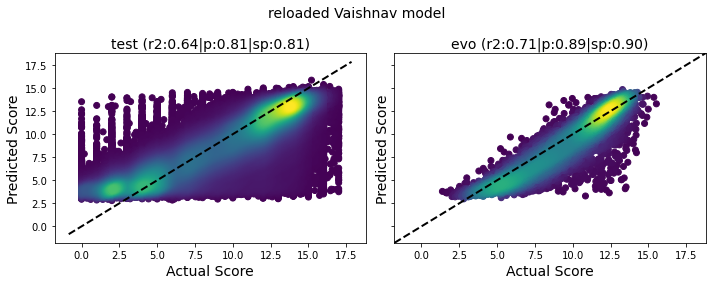

In [5]:
seq_col = 'seq'
locus_col = 'og_index'
target_col = 'expression'

# Test set split from training the model
test_df = pd.read_csv(f'data/hyak_temp/test_df.tsv',sep='\t')
# Test set from different experiment used in Vaishnav et al
evo_df = pd.read_csv(f'data/vaishnav_test_set_random_defined_media_300bp.tsv',sep='\t')

split_dfs = {
    'test':test_df, 
    'evo': evo_df
}

p_res_df = tu.parity_pred_by_split(
        model_evo.to(DEVICE),
        "reloaded Vaishnav model",
        DEVICE,
        split_dfs,
        locus_col=locus_col,
        seq_col=seq_col,
        target_col=target_col,
        splits=['test','evo'],
        #save_file=f"{out_dir}/{model_name}_parity_plot.png"
    )

looks good, now extract the relevant layers (all but the last layer)

In [9]:
def see_model_layers(model):
    extracted_layers = {k: v for k, v in model.state_dict().items()}
    extracted_layers_shapes = [(k,extracted_layers[k].shape) for k in extracted_layers]
    for x in extracted_layers_shapes:
        print(x)

In [10]:
see_model_layers(model_evo)

('conv_net.0.weight', torch.Size([32, 1, 4, 10]))
('conv_net.0.bias', torch.Size([32]))
('conv_net.4.weight', torch.Size([32, 32, 1, 6]))
('conv_net.4.bias', torch.Size([32]))
('conv_net.8.weight', torch.Size([50, 4480]))
('conv_net.8.bias', torch.Size([50]))
('conv_net.10.weight', torch.Size([50, 50]))
('conv_net.10.bias', torch.Size([50]))
('conv_net.12.weight', torch.Size([1, 50]))
('conv_net.12.bias', torch.Size([1]))


Remove the weight and bias of the final layer, so we can change the prediction task head

In [11]:
# Exclude final layer of model.state_dict 
to_exclude = ['conv_net.12.weight', 'conv_net.12.bias']
model_evo_weights = {k: v for k, v in model_evo.state_dict().items() if k not in to_exclude}
model_evo_weights.keys()

dict_keys(['conv_net.0.weight', 'conv_net.0.bias', 'conv_net.4.weight', 'conv_net.4.bias', 'conv_net.8.weight', 'conv_net.8.bias', 'conv_net.10.weight', 'conv_net.10.bias'])

### now try prediction task with warm models

In [12]:
model_res = {}
pred_dfs = {}

___Running CV0___


E:198 | train loss:0.043 | val loss: 0.833:   4%|▍         | 198/5000 [00:15<06:19, 12.67it/s]

EarlyStopping counter: 125 out of 500


E:323 | train loss:0.014 | val loss: 1.011:   6%|▋         | 324/5000 [00:25<06:00, 12.98it/s]

EarlyStopping counter: 250 out of 500


E:448 | train loss:0.007 | val loss: 1.120:   9%|▉         | 448/5000 [00:34<05:41, 13.32it/s]

EarlyStopping counter: 375 out of 500


E:571 | train loss:0.005 | val loss: 1.259:  11%|█▏        | 571/5000 [00:43<05:41, 12.98it/s]


EarlyStopping counter: 500 out of 500
Early stopping


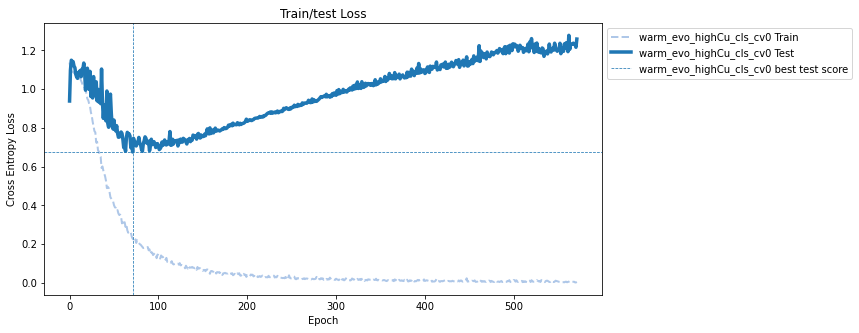

Running predictions for warm_evo_highCu_cls_cv0
___Running CV1___


E:127 | train loss:0.052 | val loss: 0.781:   3%|▎         | 128/5000 [00:09<06:10, 13.14it/s]

EarlyStopping counter: 125 out of 500


E:252 | train loss:0.014 | val loss: 0.985:   5%|▌         | 252/5000 [00:19<05:58, 13.24it/s]

EarlyStopping counter: 250 out of 500


E:377 | train loss:0.007 | val loss: 1.137:   8%|▊         | 378/5000 [00:28<05:54, 13.02it/s]

EarlyStopping counter: 375 out of 500


E:500 | train loss:0.007 | val loss: 1.285:  10%|█         | 500/5000 [00:38<05:42, 13.14it/s]


EarlyStopping counter: 500 out of 500
Early stopping


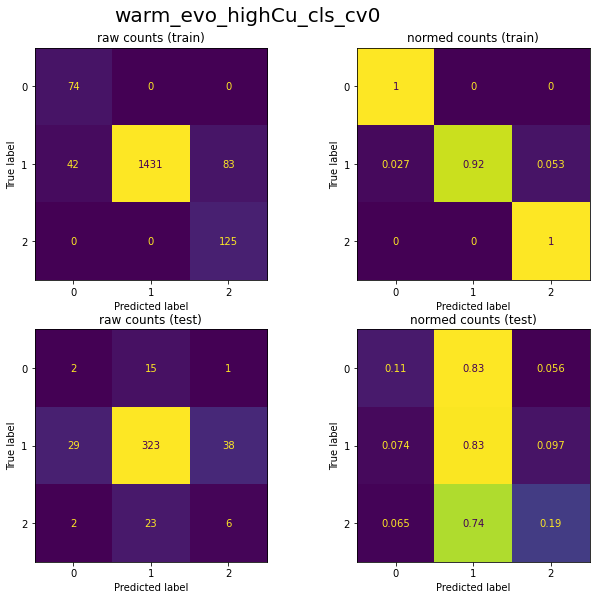

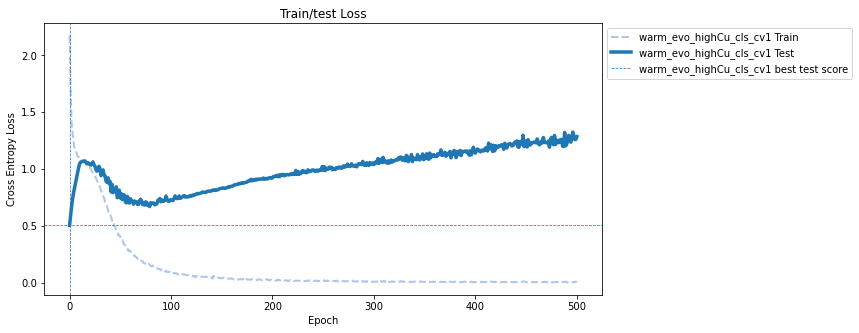

Running predictions for warm_evo_highCu_cls_cv1


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


___Running CV2___


E:184 | train loss:0.035 | val loss: 0.965:   4%|▎         | 184/5000 [00:14<06:03, 13.24it/s]

EarlyStopping counter: 125 out of 500


E:309 | train loss:0.010 | val loss: 1.203:   6%|▌         | 310/5000 [00:23<05:55, 13.21it/s]

EarlyStopping counter: 250 out of 500


E:434 | train loss:0.006 | val loss: 1.329:   9%|▊         | 434/5000 [00:33<05:49, 13.06it/s]

EarlyStopping counter: 375 out of 500


E:557 | train loss:0.004 | val loss: 1.454:  11%|█         | 557/5000 [00:42<05:40, 13.06it/s]


EarlyStopping counter: 500 out of 500
Early stopping


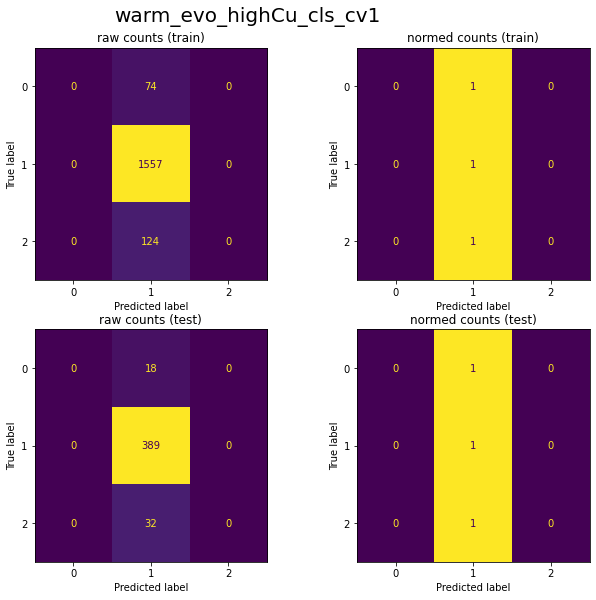

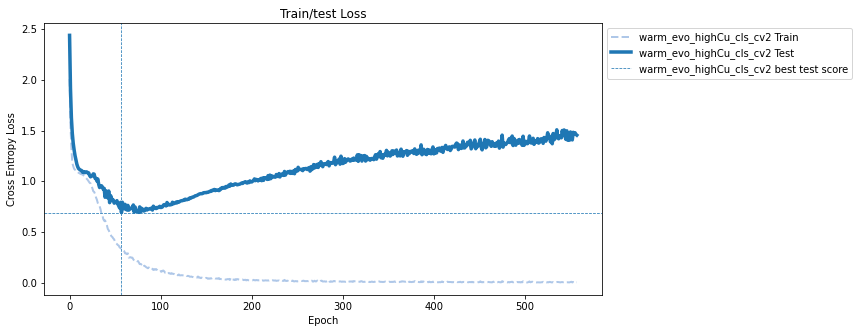

Running predictions for warm_evo_highCu_cls_cv2
___Running CV3___


E:203 | train loss:0.045 | val loss: 0.913:   4%|▍         | 203/5000 [00:15<06:05, 13.14it/s]

EarlyStopping counter: 125 out of 500


E:328 | train loss:0.010 | val loss: 1.073:   7%|▋         | 329/5000 [00:25<05:55, 13.15it/s]

EarlyStopping counter: 250 out of 500


E:453 | train loss:0.006 | val loss: 1.203:   9%|▉         | 453/5000 [00:34<05:50, 12.96it/s]

EarlyStopping counter: 375 out of 500


E:576 | train loss:0.010 | val loss: 1.292:  12%|█▏        | 576/5000 [00:44<05:39, 13.01it/s]


EarlyStopping counter: 500 out of 500
Early stopping


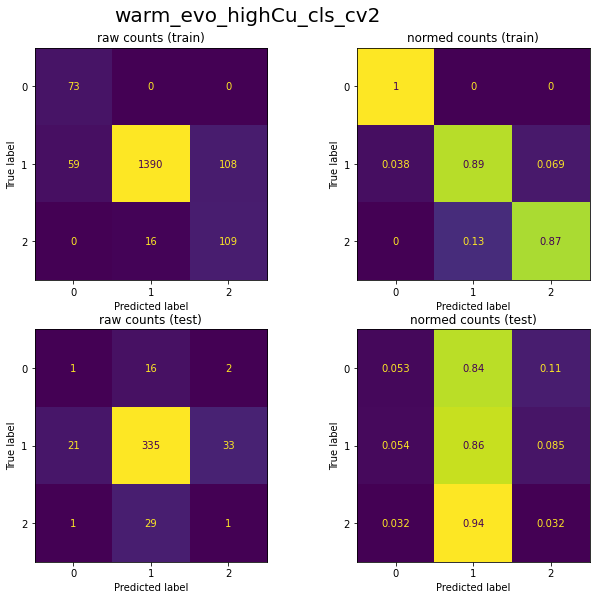

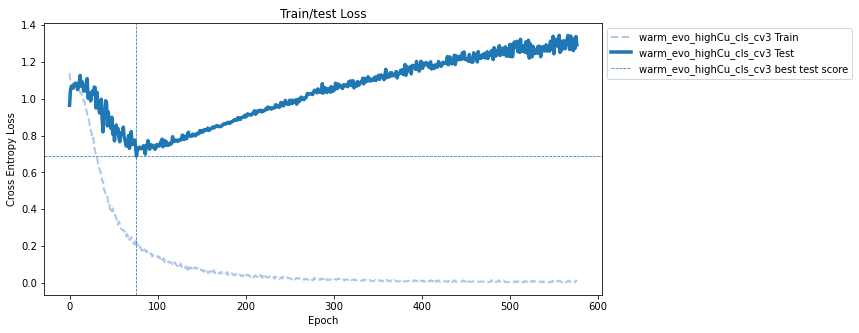

Running predictions for warm_evo_highCu_cls_cv3
___Running CV4___


E:208 | train loss:0.034 | val loss: 0.854:   4%|▍         | 208/5000 [00:16<06:12, 12.86it/s]

EarlyStopping counter: 125 out of 500


E:333 | train loss:0.018 | val loss: 1.028:   7%|▋         | 334/5000 [00:26<06:01, 12.92it/s]

EarlyStopping counter: 250 out of 500


E:458 | train loss:0.009 | val loss: 1.147:   9%|▉         | 458/5000 [00:35<05:46, 13.12it/s]

EarlyStopping counter: 375 out of 500


E:581 | train loss:0.004 | val loss: 1.255:  12%|█▏        | 581/5000 [00:45<05:44, 12.83it/s]


EarlyStopping counter: 500 out of 500
Early stopping


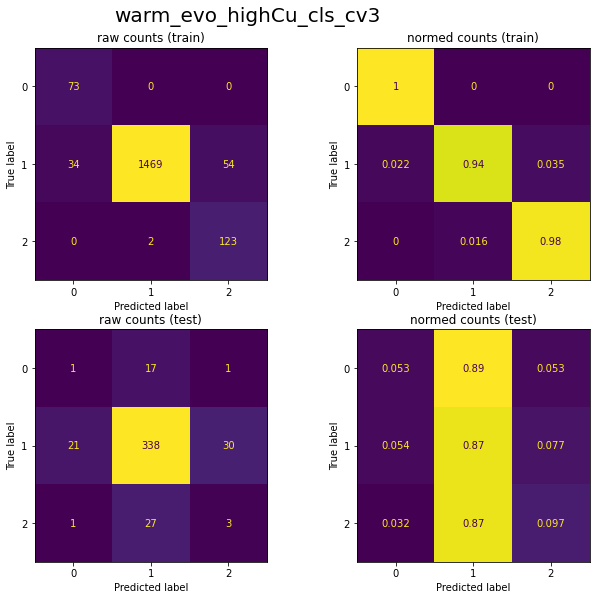

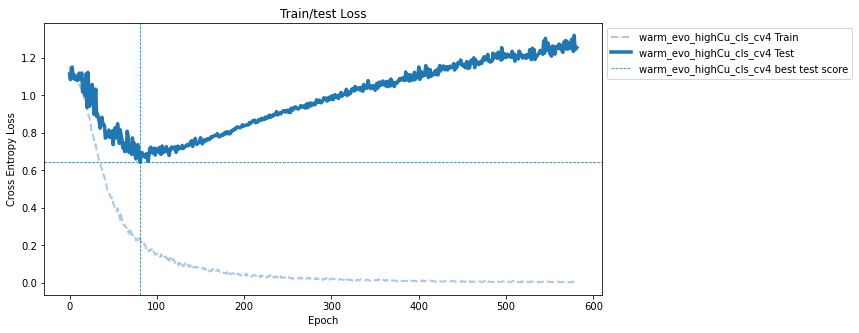

Running predictions for warm_evo_highCu_cls_cv4


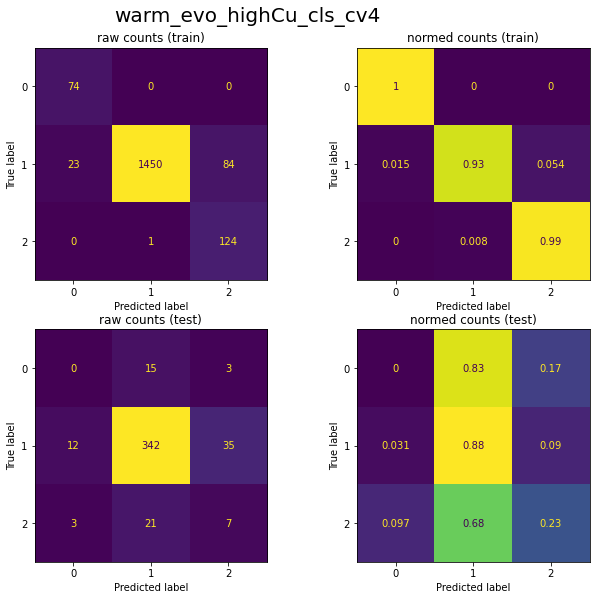

In [15]:
presplit_dir = 'highCu_cls_splits'
target_col = 'highCu_reg_UD'
seq_col = 'upstream_region'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    seq_list = [
        (train_df[seq_col].values,train_df[target_col],"train"),
        (test_df[seq_col].values,test_df[target_col],"test")
    ]

    # create data loaders
    sampler = tu.make_weighted_sampler(train_df,target_col)
    
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                    sampler=sampler,
                    shuffle=False,
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args_cu_cls = (seq_len,3)
    
    # WARM START!
    model = m.DNA_2CNN_2FC(*m_args_cu_cls,**m_kwargs)
    model.load_state_dict(model_evo_weights,strict=False)
    model_name = f"warm_evo_highCu_cls_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='classification'
    )

    model_res[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.get_confusion_stats(
        t_res['model'],
        t_res['model_name'],
        seq_list,
        DEVICE,
        title=f"{t_res['model_name']}",
        #save_file=f"{out_dir}/{model_name}_confmat.png"
    )
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "regular"
    p_res_df['fold'] = i # which cv split
    p_res_df['task'] = 'highCu_cls'
    p_res_df['start'] = 'model_evo_weights'
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs[model_name] = p_res_df

### train warm starts for shuffled seqs

___Running CV0___


E:194 | train loss:0.027 | val loss: 0.875:   4%|▍         | 194/5000 [00:15<06:08, 13.05it/s]

EarlyStopping counter: 125 out of 500


E:319 | train loss:0.012 | val loss: 1.074:   6%|▋         | 320/5000 [00:24<05:59, 13.02it/s]

EarlyStopping counter: 250 out of 500


E:444 | train loss:0.006 | val loss: 1.259:   9%|▉         | 444/5000 [00:34<05:48, 13.06it/s]

EarlyStopping counter: 375 out of 500


E:567 | train loss:0.005 | val loss: 1.301:  11%|█▏        | 567/5000 [00:43<05:43, 12.91it/s]


EarlyStopping counter: 500 out of 500
Early stopping


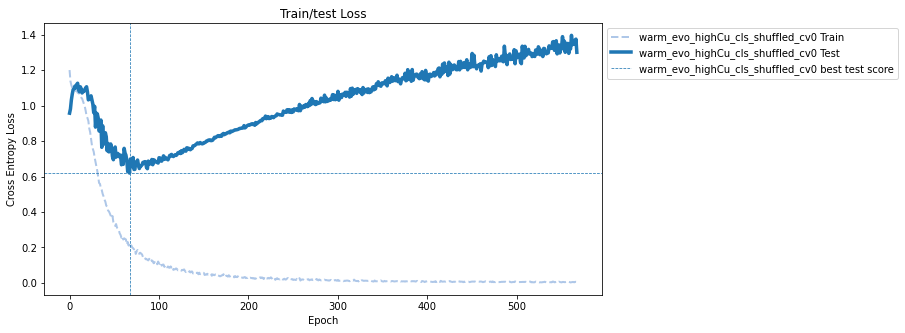

Running predictions for warm_evo_highCu_cls_shuffled_cv0
___Running CV1___


E:181 | train loss:0.034 | val loss: 0.951:   4%|▎         | 182/5000 [00:14<06:17, 12.78it/s]

EarlyStopping counter: 125 out of 500


E:306 | train loss:0.013 | val loss: 1.155:   6%|▌         | 306/5000 [00:24<06:05, 12.83it/s]

EarlyStopping counter: 250 out of 500


E:431 | train loss:0.009 | val loss: 1.263:   9%|▊         | 432/5000 [00:33<05:53, 12.91it/s]

EarlyStopping counter: 375 out of 500


E:554 | train loss:0.003 | val loss: 1.388:  11%|█         | 554/5000 [00:43<05:48, 12.76it/s]


EarlyStopping counter: 500 out of 500
Early stopping


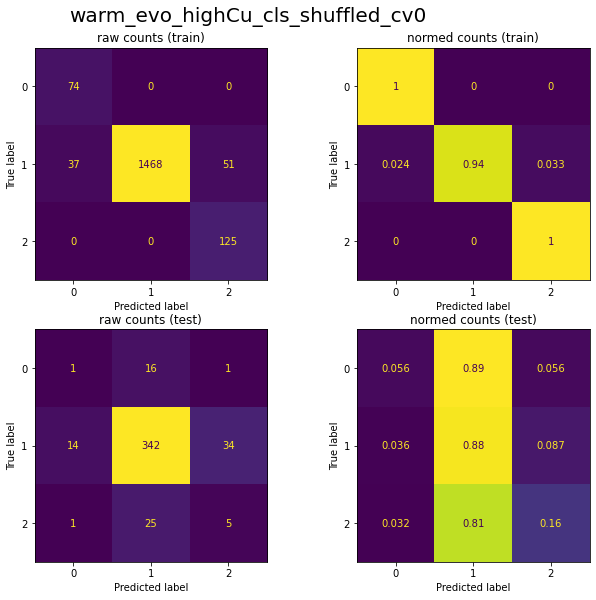

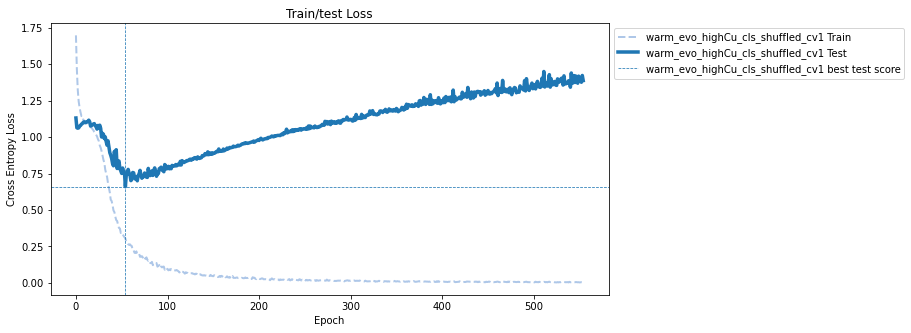

Running predictions for warm_evo_highCu_cls_shuffled_cv1
___Running CV2___


E:127 | train loss:0.065 | val loss: 0.773:   3%|▎         | 128/5000 [00:10<06:19, 12.84it/s]

EarlyStopping counter: 125 out of 500


E:252 | train loss:0.013 | val loss: 1.043:   5%|▌         | 252/5000 [00:19<06:09, 12.86it/s]

EarlyStopping counter: 250 out of 500


E:377 | train loss:0.006 | val loss: 1.162:   8%|▊         | 378/5000 [00:29<05:59, 12.86it/s]

EarlyStopping counter: 375 out of 500


E:500 | train loss:0.004 | val loss: 1.306:  10%|█         | 500/5000 [00:39<05:51, 12.82it/s]


EarlyStopping counter: 500 out of 500
Early stopping


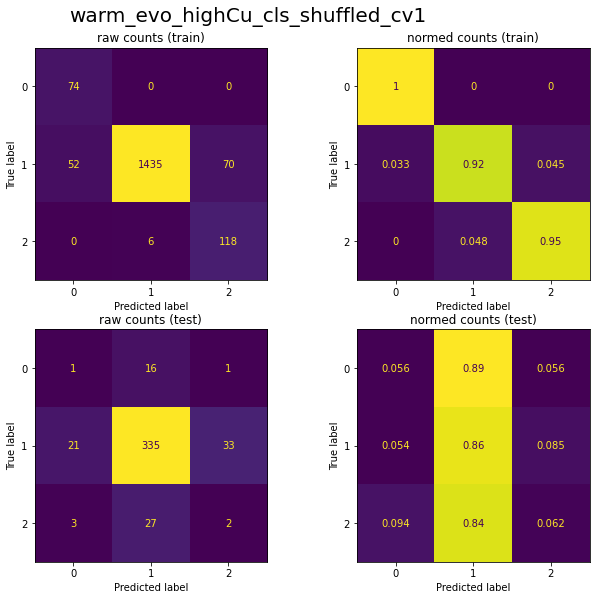

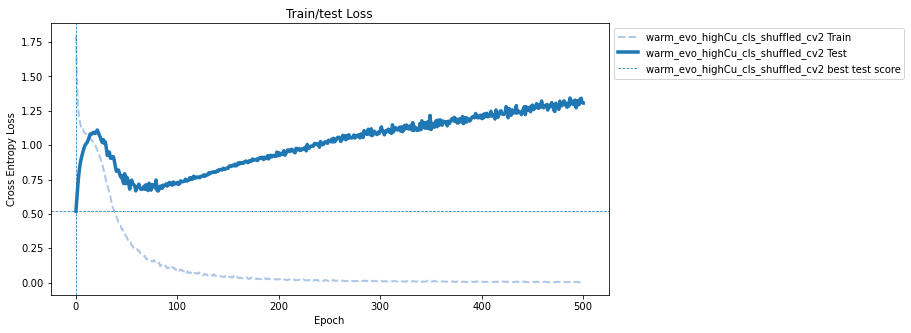

Running predictions for warm_evo_highCu_cls_shuffled_cv2
___Running CV3___


E:127 | train loss:0.068 | val loss: 0.739:   3%|▎         | 128/5000 [00:10<06:20, 12.81it/s]

EarlyStopping counter: 125 out of 500


E:252 | train loss:0.017 | val loss: 0.960:   5%|▌         | 252/5000 [00:19<06:04, 13.01it/s]

EarlyStopping counter: 250 out of 500


E:377 | train loss:0.008 | val loss: 1.102:   8%|▊         | 378/5000 [00:29<05:59, 12.87it/s]

EarlyStopping counter: 375 out of 500


E:500 | train loss:0.004 | val loss: 1.242:  10%|█         | 500/5000 [00:38<05:49, 12.87it/s]


EarlyStopping counter: 500 out of 500
Early stopping


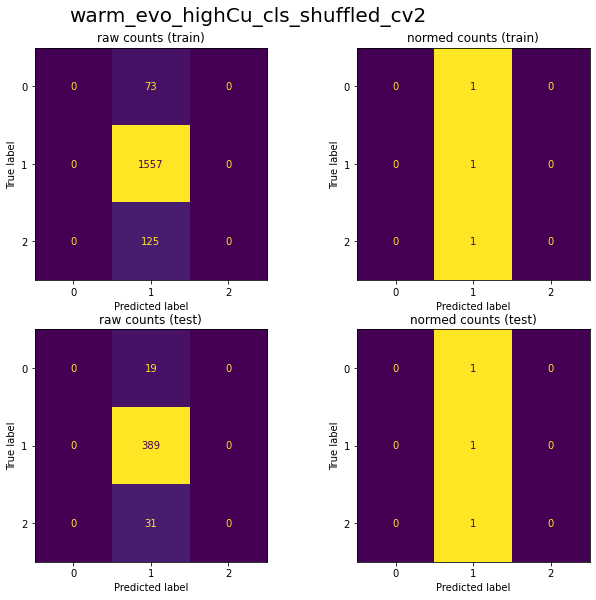

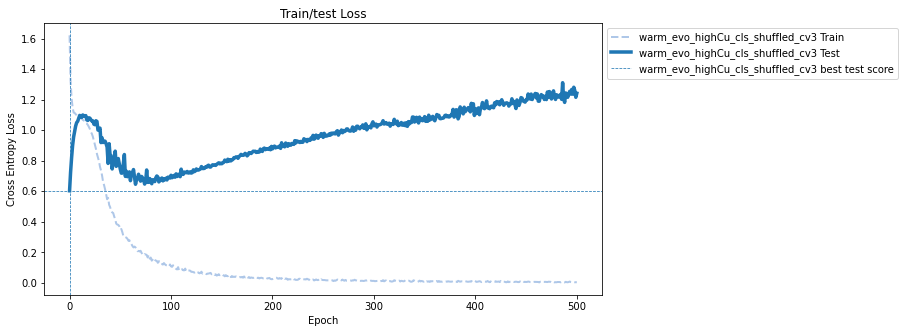

Running predictions for warm_evo_highCu_cls_shuffled_cv3
___Running CV4___


E:193 | train loss:0.034 | val loss: 1.006:   4%|▍         | 194/5000 [00:15<06:14, 12.83it/s]

EarlyStopping counter: 125 out of 500


E:318 | train loss:0.011 | val loss: 1.253:   6%|▋         | 318/5000 [00:25<06:04, 12.84it/s]

EarlyStopping counter: 250 out of 500


E:443 | train loss:0.008 | val loss: 1.403:   9%|▉         | 444/5000 [00:35<05:59, 12.67it/s]

EarlyStopping counter: 375 out of 500


E:566 | train loss:0.004 | val loss: 1.584:  11%|█▏        | 566/5000 [00:44<05:50, 12.65it/s]


EarlyStopping counter: 500 out of 500
Early stopping


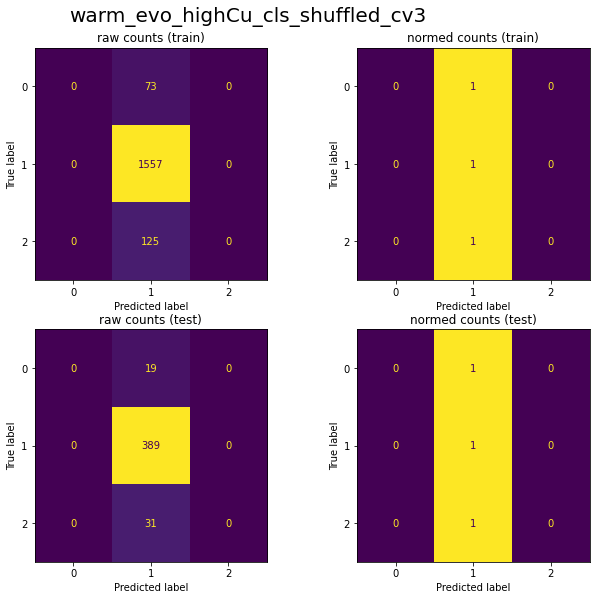

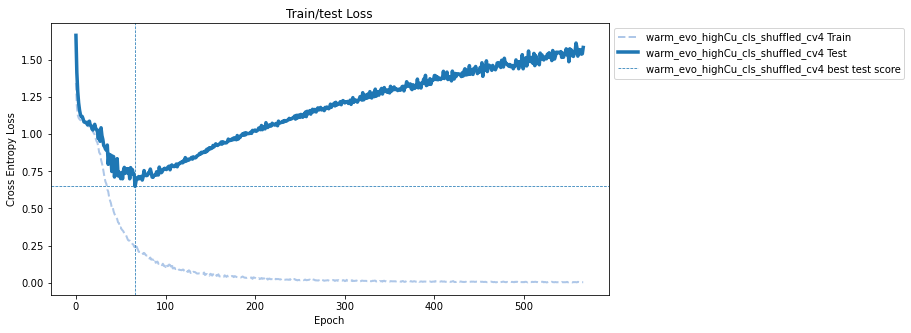

Running predictions for warm_evo_highCu_cls_shuffled_cv4


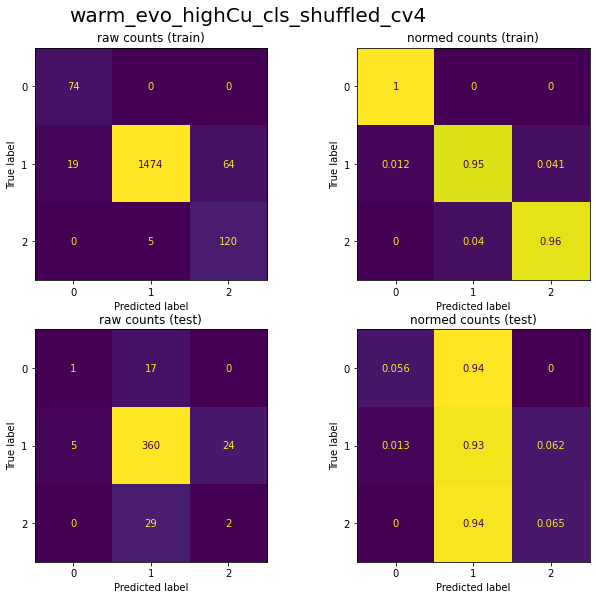

In [18]:
presplit_dir = 'highCu_cls_splits'
target_col = 'highCu_reg_UD'
seq_col = 'shuffled_seq'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    seq_list = [
        (train_df[seq_col].values,train_df[target_col],"train"),
        (test_df[seq_col].values,test_df[target_col],"test")
    ]

    # create data loaders
    sampler = tu.make_weighted_sampler(train_df,target_col)
    
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                    sampler=sampler,
                    shuffle=False,
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args_cu_cls = (seq_len,3)
    
    # WARM START!
    model = m.DNA_2CNN_2FC(*m_args_cu_cls,**m_kwargs)
    model.load_state_dict(model_evo_weights,strict=False)
    model_name = f"warm_evo_highCu_cls_shuffled_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='classification'
    )

    model_res[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.get_confusion_stats(
        t_res['model'],
        t_res['model_name'],
        seq_list,
        DEVICE,
        title=f"{t_res['model_name']}",
        #save_file=f"{out_dir}/{model_name}_confmat.png"
    )
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "shuffled"
    p_res_df['fold'] = i # which cv split
    p_res_df['task'] = 'highCu_cls'
    p_res_df['start'] = 'model_evo_weights'
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs[model_name] = p_res_df

In [19]:
all_preds = pd.concat([pred_dfs[x] for x in pred_dfs])
all_preds

,model_name,split,mac_precision,mac_recall,mac_f1,support,model_type,seq_mode,fold,task,start,best_val_score,epoch_stop,total_time
0,warm_evo_highCu_cls_cv0,train,0.746298,0.973222,0.829283,1755,CNN,regular,0,highCu_cls,model_evo_weights,0.676145,71,43.989408
1,warm_evo_highCu_cls_cv0,test,0.362892,0.377622,0.365504,439,CNN,regular,0,highCu_cls,model_evo_weights,0.676145,71,43.989408
0,warm_evo_highCu_cls_cv1,train,0.295726,0.333333,0.313406,1755,CNN,regular,1,highCu_cls,model_evo_weights,0.503945,0,38.046286
1,warm_evo_highCu_cls_cv1,test,0.295368,0.333333,0.313205,439,CNN,regular,1,highCu_cls,model_evo_weights,0.503945,0,38.046286
0,warm_evo_highCu_cls_cv2,train,0.681318,0.921581,0.762620,1755,CNN,regular,2,highCu_cls,model_evo_weights,0.690886,57,42.645337
1,warm_evo_highCu_cls_cv2,test,0.317612,0.315357,0.316244,439,CNN,regular,2,highCu_cls,model_evo_weights,0.690886,57,42.645337
0,warm_evo_highCu_cls_cv3,train,0.791933,0.975827,0.865319,1755,CNN,regular,3,highCu_cls,model_evo_weights,0.688607,76,44.269108
1,warm_evo_highCu_cls_cv3,test,0.338843,0.339433,0.338903,439,CNN,regular,3,highCu_cls,model_evo_weights,0.688607,76,44.269108
0,warm_evo_highCu_cls_cv4,train,0.786117,0.974426,0.858113,1756,CNN,regular,4,highCu_cls,model_evo_weights,0.642734,81,45.273475
1,warm_evo_highCu_cls_cv4,test,0.353439,0.368328,0.358666,438,CNN,regular,4,highCu_cls,model_evo_weights,0.642734,81,45.273475


In [20]:
def plot_metric(df,metric):
    sns.barplot(data=df,y='model_name',x=metric,hue='split',dodge=True)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.xlabel(f"{metric} score",fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel("")
    plt.yticks(fontsize=14)
    plt.show()

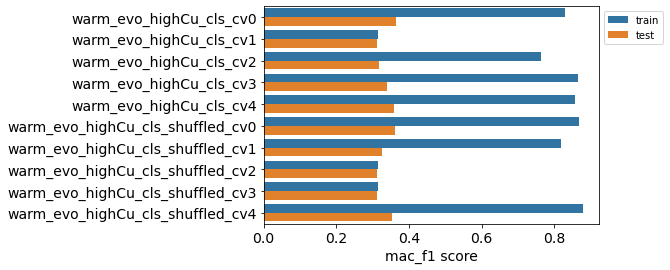

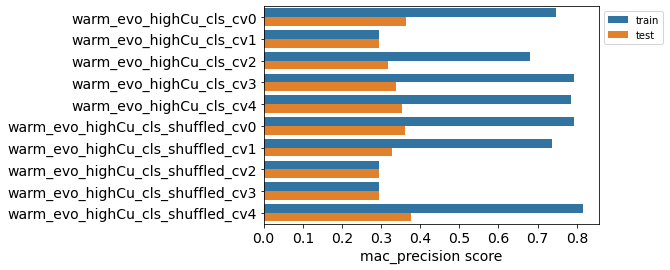

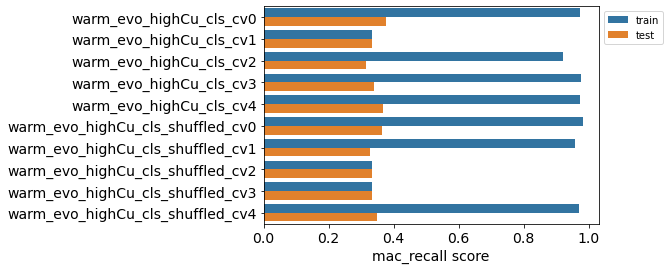

In [21]:
plot_metric(all_preds,'mac_f1')
plot_metric(all_preds,'mac_precision')
plot_metric(all_preds,'mac_recall')

In [22]:
df_train = all_preds[all_preds['split']=='train']
df_test = all_preds[all_preds['split']=='test']

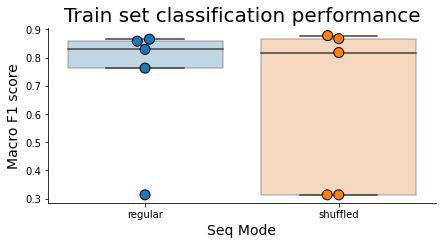

In [23]:
g = sns.catplot(
    data=df_train, x='seq_mode', y='mac_f1',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='mac_f1',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Train set classification performance",fontsize=20)
plt.show()

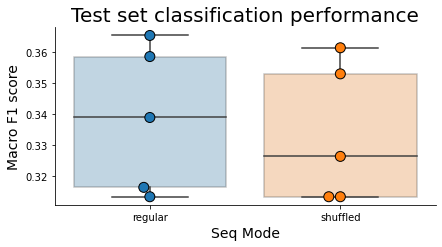

In [24]:
g = sns.catplot(
    data=df_test, x='seq_mode', y='mac_f1',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='mac_f1',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Test set classification performance",fontsize=20)
plt.show()

In [25]:
from scipy.stats import ttest_ind

In [26]:
regular_scores = df_test[df_test['seq_mode']=='regular']['mac_f1'].values
shuffled_scores = df_test[df_test['seq_mode']=='shuffled']['mac_f1'].values
print("T-test:",ttest_ind(regular_scores, shuffled_scores))
print()
print("Mean Mac F1 for regular seqs:",np.mean(regular_scores))
print("Mean Mac F1 for shuffled seqs:",np.mean(shuffled_scores))

T-test: Ttest_indResult(statistic=0.3439196366072715, pvalue=0.739771499734784)

Mean Mac F1 for regular seqs: 0.3385042713813379
Mean Mac F1 for shuffled seqs: 0.3334531581056448


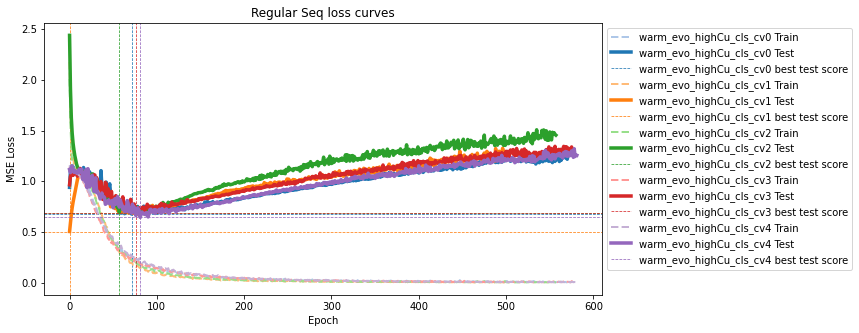

<Figure size 432x288 with 0 Axes>

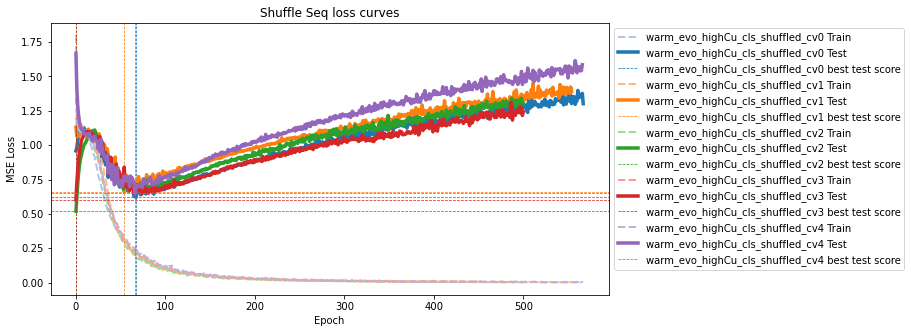

<Figure size 432x288 with 0 Axes>

In [27]:
tu.quick_loss_plot(
    [model_res[x]['data_label'][0] for x in model_res if "shuffle" not in x],
    title="Regular Seq loss curves",
    loss_str = "MSE Loss",
    save_file = 'out_warmStart_highCu_cls/regular_seq_W:evo_loss_plot.png'
)

tu.quick_loss_plot(
    [model_res[x]['data_label'][0] for x in model_res if "shuffle" in x],
    title="Shuffle Seq loss curves",
    loss_str = "MSE Loss",
    save_file = 'out_warmStart_highCu_cls/shuffle_seq_W:evo_loss_plot.png'
)

## Try warm start on 5org_cls for *Regression* task

In [29]:
model_res_regr = {}
pred_dfs_regr = {}

___Running CV0___


E:236 | train loss:1.914 | val loss: 4.883:   5%|▍         | 236/5000 [00:18<06:13, 12.76it/s]

EarlyStopping counter: 125 out of 500


E:361 | train loss:1.198 | val loss: 5.090:   7%|▋         | 362/5000 [00:28<06:09, 12.56it/s]

EarlyStopping counter: 250 out of 500


E:486 | train loss:0.872 | val loss: 5.149:  10%|▉         | 486/5000 [00:38<05:52, 12.82it/s]

EarlyStopping counter: 375 out of 500


E:609 | train loss:0.729 | val loss: 5.240:  12%|█▏        | 609/5000 [00:48<05:48, 12.61it/s]


EarlyStopping counter: 500 out of 500
Early stopping


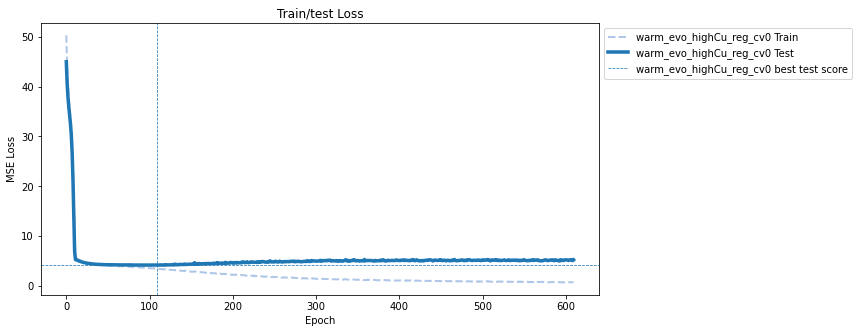

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_evo_highCu_reg_cv0


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_evo_highCu_reg_cv0


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


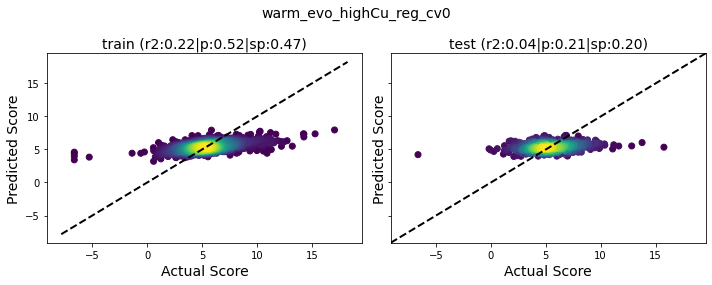

___Running CV1___


E:260 | train loss:2.150 | val loss: 4.619:   5%|▌         | 261/5000 [00:20<06:13, 12.68it/s]

EarlyStopping counter: 125 out of 500


E:385 | train loss:1.339 | val loss: 4.898:   8%|▊         | 385/5000 [00:30<05:59, 12.85it/s]

EarlyStopping counter: 250 out of 500


E:510 | train loss:1.143 | val loss: 4.824:  10%|█         | 511/5000 [00:40<05:57, 12.56it/s]

EarlyStopping counter: 375 out of 500


E:633 | train loss:0.936 | val loss: 4.880:  13%|█▎        | 633/5000 [00:49<05:43, 12.72it/s]


EarlyStopping counter: 500 out of 500
Early stopping


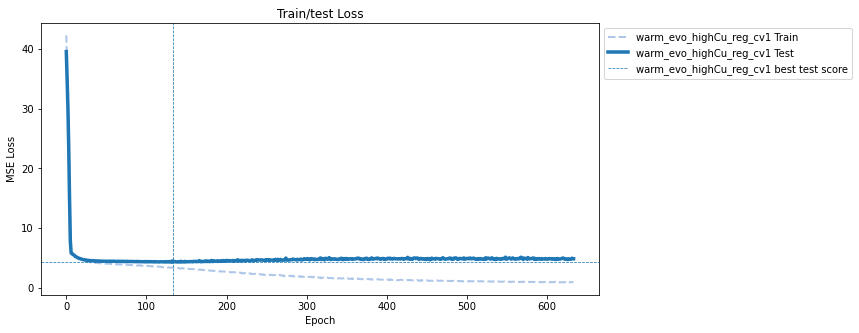

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_evo_highCu_reg_cv1


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_evo_highCu_reg_cv1


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


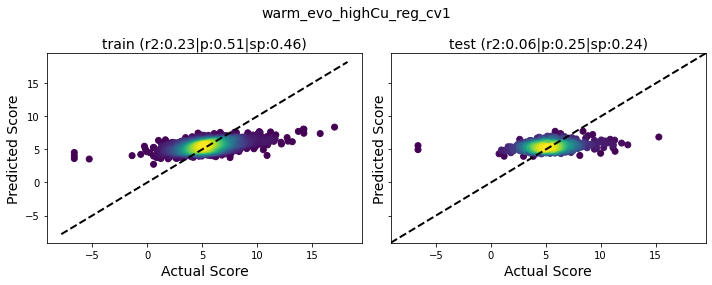

___Running CV2___


E:220 | train loss:2.097 | val loss: 3.811:   4%|▍         | 221/5000 [00:17<06:07, 12.99it/s]

EarlyStopping counter: 125 out of 500


E:345 | train loss:1.169 | val loss: 3.902:   7%|▋         | 345/5000 [00:27<05:58, 12.99it/s]

EarlyStopping counter: 250 out of 500


E:470 | train loss:0.895 | val loss: 3.804:   9%|▉         | 471/5000 [00:36<05:53, 12.81it/s]

EarlyStopping counter: 375 out of 500


E:593 | train loss:0.717 | val loss: 3.680:  12%|█▏        | 593/5000 [00:46<05:44, 12.78it/s]


EarlyStopping counter: 500 out of 500
Early stopping


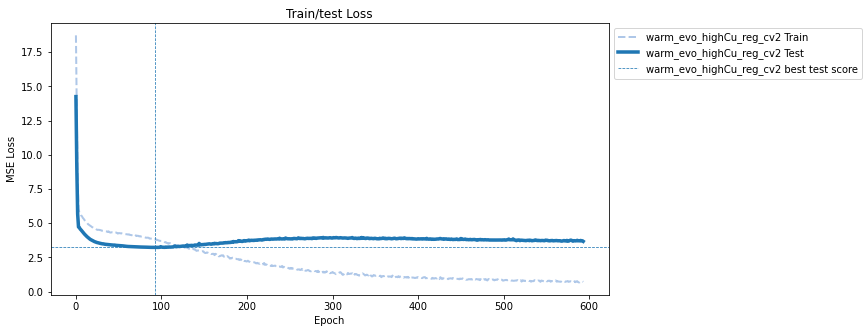

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_evo_highCu_reg_cv2


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_evo_highCu_reg_cv2


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


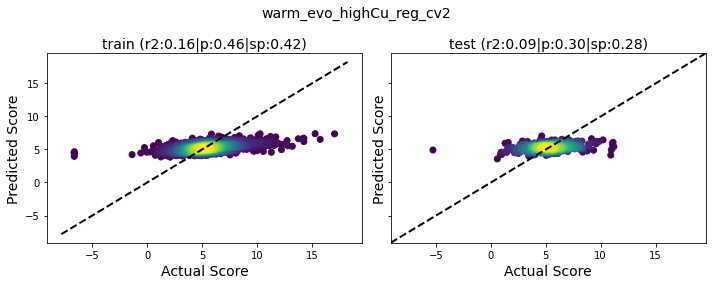

___Running CV3___


E:177 | train loss:2.670 | val loss: 4.649:   4%|▎         | 177/5000 [00:14<06:19, 12.70it/s]

EarlyStopping counter: 125 out of 500


E:302 | train loss:1.478 | val loss: 4.924:   6%|▌         | 303/5000 [00:24<06:12, 12.60it/s]

EarlyStopping counter: 250 out of 500


E:427 | train loss:1.008 | val loss: 4.974:   9%|▊         | 427/5000 [00:34<06:02, 12.62it/s]

EarlyStopping counter: 375 out of 500


E:550 | train loss:0.838 | val loss: 4.781:  11%|█         | 550/5000 [00:43<05:55, 12.53it/s]


EarlyStopping counter: 500 out of 500
Early stopping


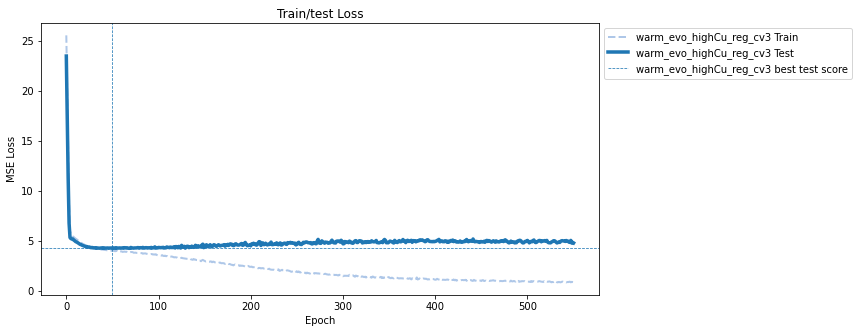

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_evo_highCu_reg_cv3


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_evo_highCu_reg_cv3


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


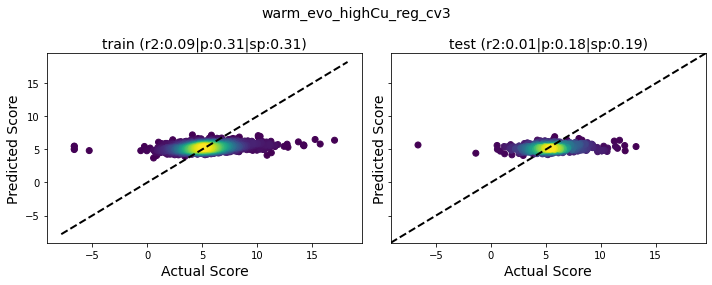

___Running CV4___


E:230 | train loss:1.943 | val loss: 5.117:   5%|▍         | 230/5000 [00:19<06:32, 12.14it/s]

EarlyStopping counter: 125 out of 500


E:355 | train loss:1.341 | val loss: 5.398:   7%|▋         | 356/5000 [00:29<06:29, 11.94it/s]

EarlyStopping counter: 250 out of 500


E:480 | train loss:1.027 | val loss: 5.405:  10%|▉         | 480/5000 [00:40<06:16, 12.02it/s]

EarlyStopping counter: 375 out of 500


E:603 | train loss:0.878 | val loss: 5.525:  12%|█▏        | 603/5000 [00:50<06:05, 12.02it/s]


EarlyStopping counter: 500 out of 500
Early stopping


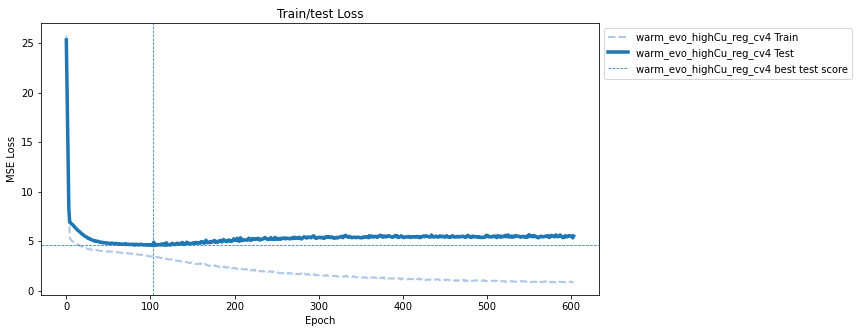

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_evo_highCu_reg_cv4


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_evo_highCu_reg_cv4


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


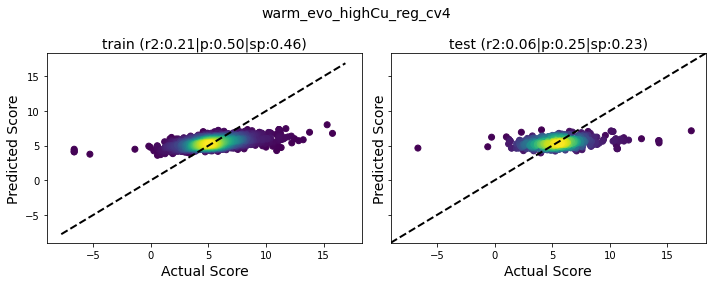

In [30]:
presplit_dir = 'highCu_logTPM_reg_splits'
target_col = 'highCu'
seq_col = 'upstream_region'
locus_col = 'locus_tag'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    split_dfs = {
        'train':train_df,
        'test':test_df
    }

    # create data loaders    
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                    # NO SAMPLER for regression
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args_cu_reg = (seq_len,1) # single task regression
    
    # WARM START!
    model = m.DNA_2CNN_2FC(*m_args_cu_reg,**m_kwargs)
    model.load_state_dict(model_evo_weights,strict=False)
    model_name = f"warm_evo_highCu_reg_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='regression'
    )

    model_res_regr[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.parity_pred_by_split(
        model,
        model_name,
        DEVICE,
        split_dfs,
        locus_col=locus_col,
        seq_col=seq_col,
        target_col=target_col,
        splits=['train','test'],
        #save_file=f"{out_dir}/{model_name}_parity_plot.png"
    )
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "regular"
    p_res_df['fold'] = i # which cv split
    p_res_df['task'] = 'highCu_logTPM_regr'
    p_res_df['start'] = 'model_evo_weights'
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs_regr[model_name] = p_res_df

### Regression from 5org_cls shuffled

___Running CV0___


E:182 | train loss:2.135 | val loss: 5.245:   4%|▎         | 183/5000 [00:14<06:16, 12.79it/s]

EarlyStopping counter: 125 out of 500


E:307 | train loss:1.359 | val loss: 5.585:   6%|▌         | 307/5000 [00:24<06:11, 12.64it/s]

EarlyStopping counter: 250 out of 500


E:432 | train loss:0.992 | val loss: 5.661:   9%|▊         | 433/5000 [00:34<05:56, 12.79it/s]

EarlyStopping counter: 375 out of 500


E:555 | train loss:0.860 | val loss: 5.419:  11%|█         | 555/5000 [00:44<05:54, 12.53it/s]


EarlyStopping counter: 500 out of 500
Early stopping


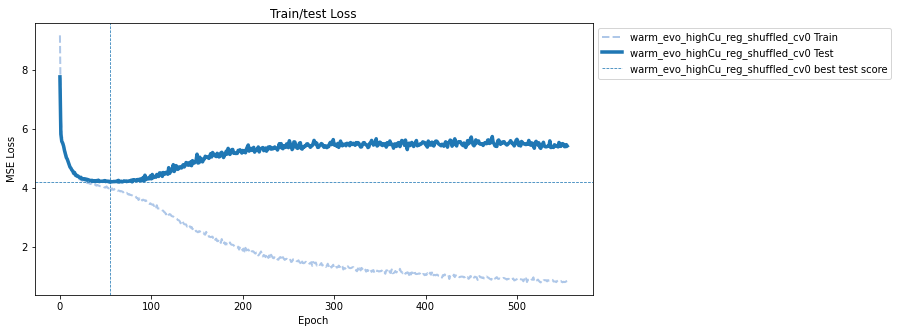

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_evo_highCu_reg_shuffled_cv0


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_evo_highCu_reg_shuffled_cv0


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


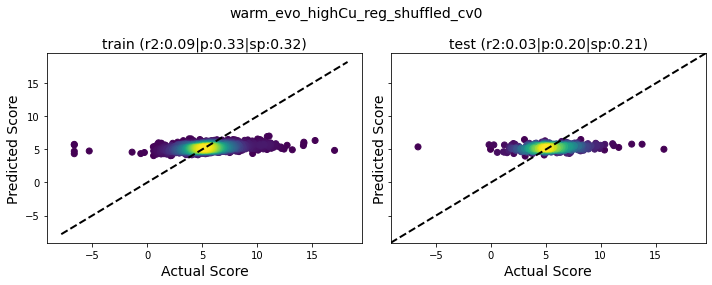

___Running CV1___


E:195 | train loss:2.402 | val loss: 5.567:   4%|▍         | 195/5000 [00:15<06:17, 12.73it/s]

EarlyStopping counter: 125 out of 500


E:320 | train loss:1.310 | val loss: 5.829:   6%|▋         | 321/5000 [00:25<06:10, 12.64it/s]

EarlyStopping counter: 250 out of 500


E:445 | train loss:0.933 | val loss: 5.907:   9%|▉         | 445/5000 [00:35<06:02, 12.57it/s]

EarlyStopping counter: 375 out of 500


E:568 | train loss:0.752 | val loss: 5.858:  11%|█▏        | 568/5000 [00:45<05:52, 12.57it/s]


EarlyStopping counter: 500 out of 500
Early stopping


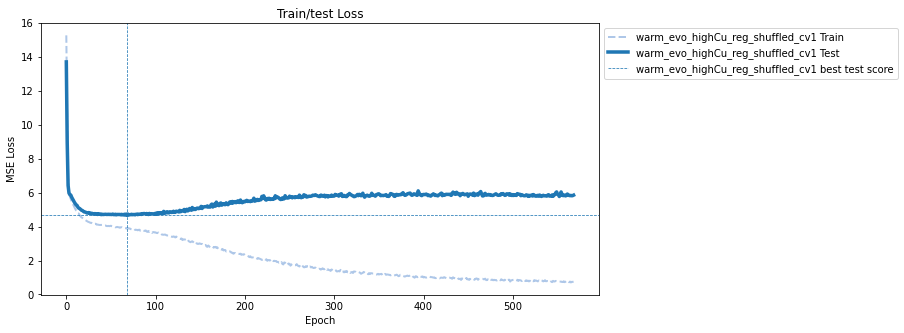

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_evo_highCu_reg_shuffled_cv1


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_evo_highCu_reg_shuffled_cv1


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


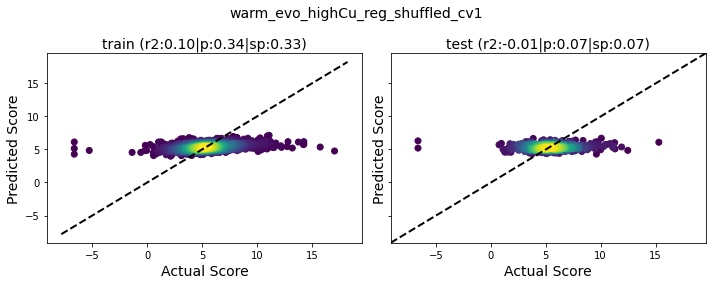

___Running CV2___


E:192 | train loss:2.652 | val loss: 4.224:   4%|▍         | 192/5000 [00:15<06:10, 12.99it/s]

EarlyStopping counter: 125 out of 500


E:317 | train loss:1.538 | val loss: 4.773:   6%|▋         | 318/5000 [00:24<06:02, 12.92it/s]

EarlyStopping counter: 250 out of 500


E:442 | train loss:1.043 | val loss: 4.728:   9%|▉         | 442/5000 [00:34<05:48, 13.06it/s]

EarlyStopping counter: 375 out of 500


E:565 | train loss:0.803 | val loss: 4.674:  11%|█▏        | 565/5000 [00:44<05:46, 12.81it/s]


EarlyStopping counter: 500 out of 500
Early stopping


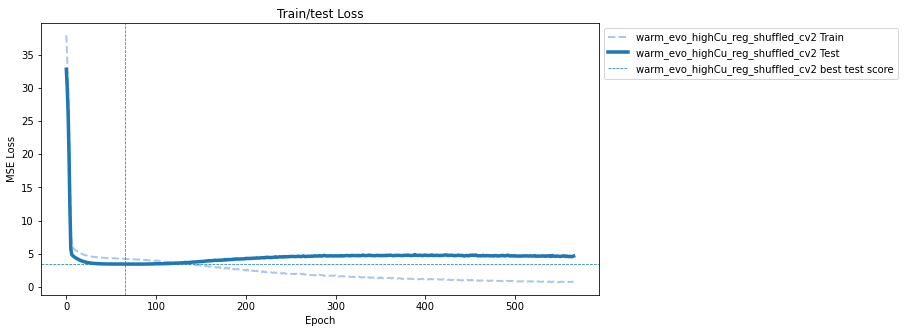

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_evo_highCu_reg_shuffled_cv2


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_evo_highCu_reg_shuffled_cv2


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


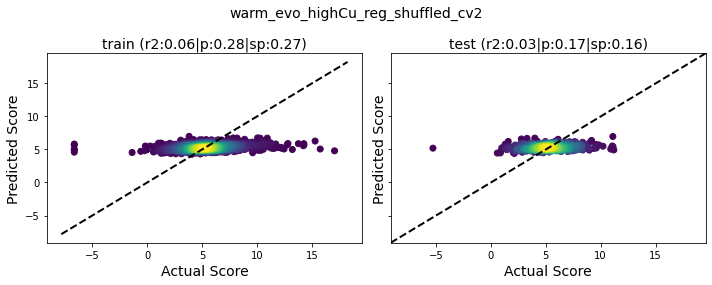

___Running CV3___


E:188 | train loss:2.128 | val loss: 5.139:   4%|▍         | 189/5000 [00:14<06:14, 12.83it/s]

EarlyStopping counter: 125 out of 500


E:313 | train loss:1.334 | val loss: 6.225:   6%|▋         | 313/5000 [00:24<06:04, 12.86it/s]

EarlyStopping counter: 250 out of 500


E:438 | train loss:1.026 | val loss: 6.200:   9%|▉         | 439/5000 [00:34<05:51, 12.99it/s]

EarlyStopping counter: 375 out of 500


E:561 | train loss:0.916 | val loss: 6.007:  11%|█         | 561/5000 [00:43<05:47, 12.78it/s]


EarlyStopping counter: 500 out of 500
Early stopping


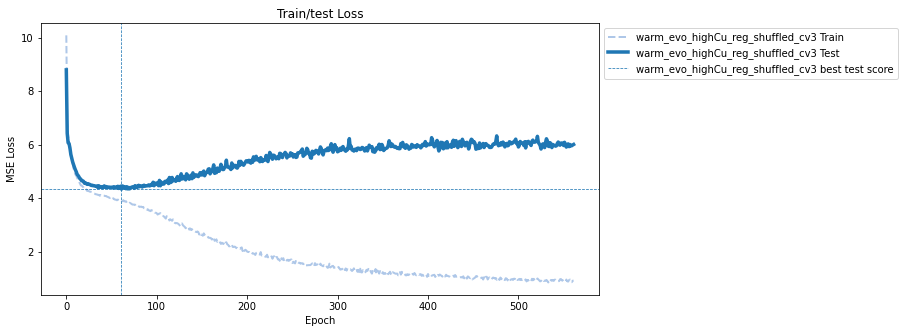

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_evo_highCu_reg_shuffled_cv3


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_evo_highCu_reg_shuffled_cv3


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


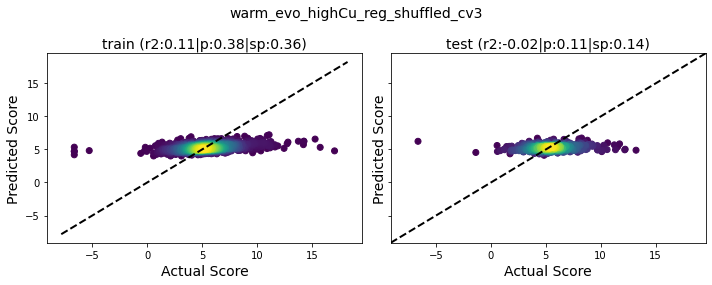

___Running CV4___


E:203 | train loss:2.277 | val loss: 5.429:   4%|▍         | 203/5000 [00:16<06:25, 12.44it/s]

EarlyStopping counter: 125 out of 500


E:328 | train loss:1.308 | val loss: 5.958:   7%|▋         | 329/5000 [00:26<06:18, 12.35it/s]

EarlyStopping counter: 250 out of 500


E:453 | train loss:0.906 | val loss: 6.043:   9%|▉         | 453/5000 [00:36<05:56, 12.74it/s]

EarlyStopping counter: 375 out of 500


E:576 | train loss:0.719 | val loss: 5.972:  12%|█▏        | 576/5000 [00:46<05:53, 12.50it/s]


EarlyStopping counter: 500 out of 500
Early stopping


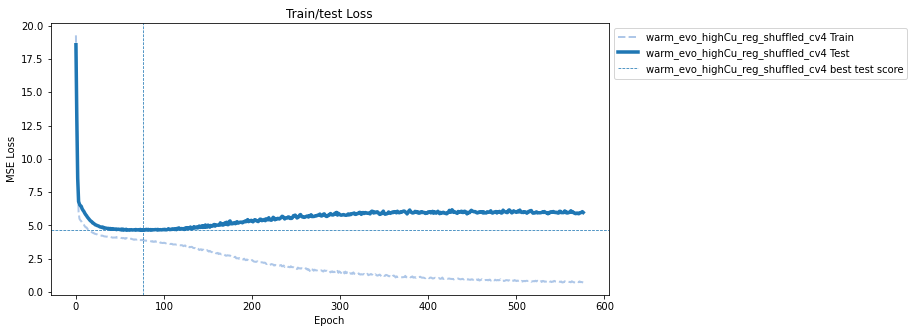

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_evo_highCu_reg_shuffled_cv4


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_evo_highCu_reg_shuffled_cv4


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


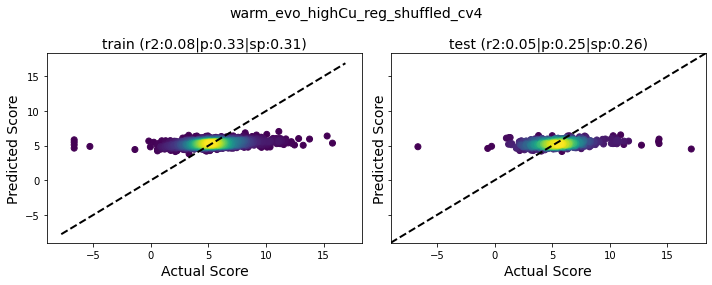

In [31]:
presplit_dir = 'highCu_logTPM_reg_splits'
target_col = 'highCu'
seq_col = 'shuffled_seq'
locus_col = 'locus_tag'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    split_dfs = {
        'train':train_df,
        'test':test_df
    }

    # create data loaders    
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                    # NO SAMPLER for regression
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args_cu_reg = (seq_len,1) # single task regression
    
    # WARM START!
    model = m.DNA_2CNN_2FC(*m_args_cu_reg,**m_kwargs)
    model.load_state_dict(model_evo_weights,strict=False)
    model_name = f"warm_evo_highCu_reg_shuffled_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='regression'
    )

    model_res_regr[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.parity_pred_by_split(
        model,
        model_name,
        DEVICE,
        split_dfs,
        locus_col=locus_col,
        seq_col=seq_col,
        target_col=target_col,
        splits=['train','test'],
        #save_file=f"{out_dir}/{model_name}_parity_plot.png"
    )
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "shuffled"
    p_res_df['fold'] = i # which cv split
    p_res_df['task'] = 'highCu_logTPM_regr'
    p_res_df['start'] = 'model_evo_weights'
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs_regr[model_name] = p_res_df

### Compare overall predictions of warm start for regression

In [32]:
all_preds_regr = pd.concat([pred_dfs_regr[x] for x in pred_dfs_regr])
all_preds_regr

,model_name,split,r2,pearson,spearman,model_type,seq_mode,fold,task,start,best_val_score,epoch_stop,total_time
0,warm_evo_highCu_reg_cv0,train,0.220695,0.519858,0.470980,CNN,regular,0,highCu_logTPM_regr,model_evo_weights,4.178997,109,48.304527
1,warm_evo_highCu_reg_cv0,test,0.038720,0.214002,0.196521,CNN,regular,0,highCu_logTPM_regr,model_evo_weights,4.178997,109,48.304527
0,warm_evo_highCu_reg_cv1,train,0.233242,0.511296,0.458964,CNN,regular,1,highCu_logTPM_regr,model_evo_weights,4.329524,133,49.764724
1,warm_evo_highCu_reg_cv1,test,0.060839,0.252197,0.235517,CNN,regular,1,highCu_logTPM_regr,model_evo_weights,4.329524,133,49.764724
0,warm_evo_highCu_reg_cv2,train,0.163215,0.459408,0.416076,CNN,regular,2,highCu_logTPM_regr,model_evo_weights,3.236889,93,46.421821
1,warm_evo_highCu_reg_cv2,test,0.090468,0.302619,0.283590,CNN,regular,2,highCu_logTPM_regr,model_evo_weights,3.236889,93,46.421821
0,warm_evo_highCu_reg_cv3,train,0.087169,0.312254,0.310116,CNN,regular,3,highCu_logTPM_regr,model_evo_weights,4.230066,50,43.895768
1,warm_evo_highCu_reg_cv3,test,0.009079,0.180122,0.194783,CNN,regular,3,highCu_logTPM_regr,model_evo_weights,4.230066,50,43.895768
0,warm_evo_highCu_reg_cv4,train,0.207073,0.496664,0.456433,CNN,regular,4,highCu_logTPM_regr,model_evo_weights,4.580793,103,50.190502
1,warm_evo_highCu_reg_cv4,test,0.059501,0.249411,0.230749,CNN,regular,4,highCu_logTPM_regr,model_evo_weights,4.580793,103,50.190502


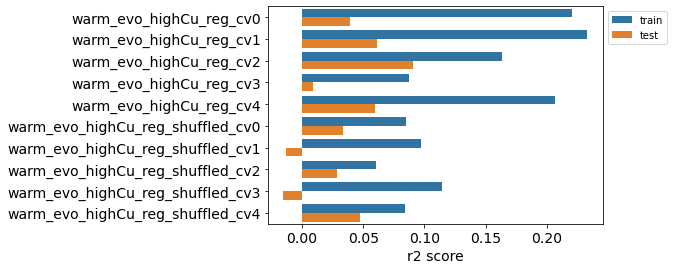

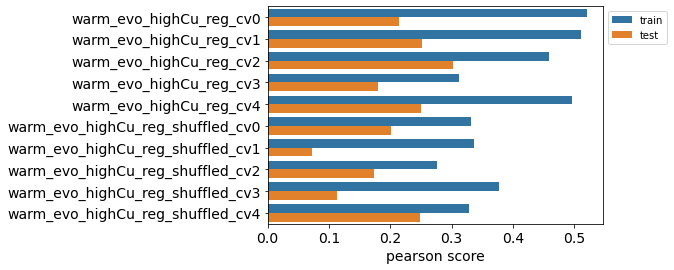

In [33]:
plot_metric(all_preds_regr,'r2')
plot_metric(all_preds_regr,'pearson')

In [34]:
df_train = all_preds_regr[all_preds_regr['split']=='train']
df_test = all_preds_regr[all_preds_regr['split']=='test']

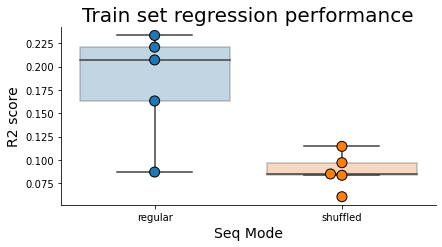

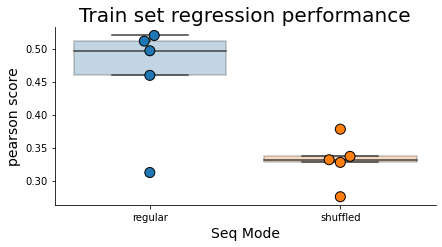

In [35]:
# TRAIN
g = sns.catplot(
    data=df_train, x='seq_mode', y='r2',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='r2',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('R2 score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Train set regression performance",fontsize=20)
plt.show()

g = sns.catplot(
    data=df_train, x='seq_mode', y='pearson',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='pearson',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('pearson score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Train set regression performance",fontsize=20)
plt.show()

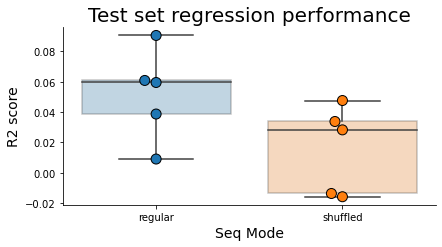

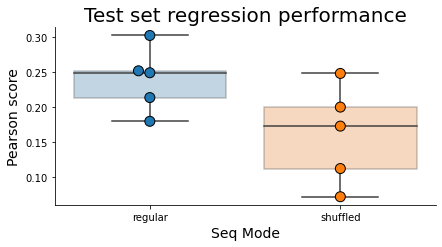

In [36]:
g = sns.catplot(
    data=df_test, x='seq_mode', y='r2',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='r2',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('R2 score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Test set regression performance",fontsize=20)
plt.show()

g = sns.catplot(
    data=df_test, x='seq_mode', y='pearson',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='pearson',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Pearson score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Test set regression performance",fontsize=20)
plt.show()

In [37]:
regular_r2scores = df_test[df_test['seq_mode']=='regular']['r2'].values
shuffled_r2scores = df_test[df_test['seq_mode']=='shuffled']['r2'].values
print("R2")
print(ttest_ind(regular_r2scores, shuffled_r2scores))

regular_pearsonscores = df_test[df_test['seq_mode']=='regular']['pearson'].values
shuffled_pearsonscores = df_test[df_test['seq_mode']=='shuffled']['pearson'].values
print("Pearson")
print(ttest_ind(regular_pearsonscores, shuffled_pearsonscores))

R2
Ttest_indResult(statistic=1.907706305579189, pvalue=0.09285886045958613)
Pearson
Ttest_indResult(statistic=2.0928842795946374, pvalue=0.06970472402912573)


In [38]:
print("Mean R2 for regular seqs:",np.mean(regular_r2scores))
print("Mean R2 for shuffled seqs:",np.mean(shuffled_r2scores))
print()
print("Mean Pearson for regular seqs:",np.mean(regular_pearsonscores))
print("Mean Pearson for shuffled seqs:",np.mean(shuffled_pearsonscores))

Mean R2 for regular seqs: 0.05172128811396306
Mean R2 for shuffled seqs: 0.01606783046025211

Mean Pearson for regular seqs: 0.23967038963371498
Mean Pearson for shuffled seqs: 0.16145761838809733


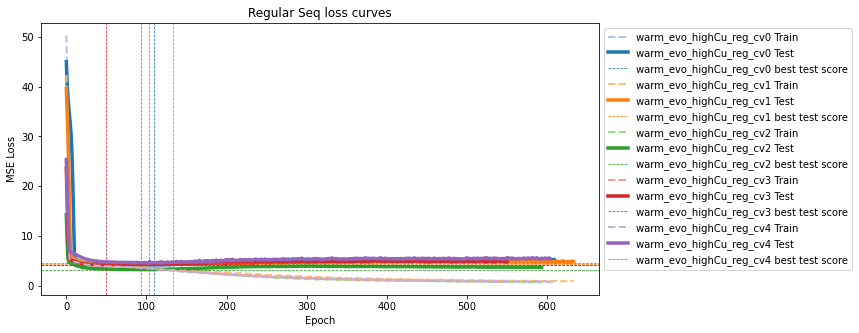

<Figure size 432x288 with 0 Axes>

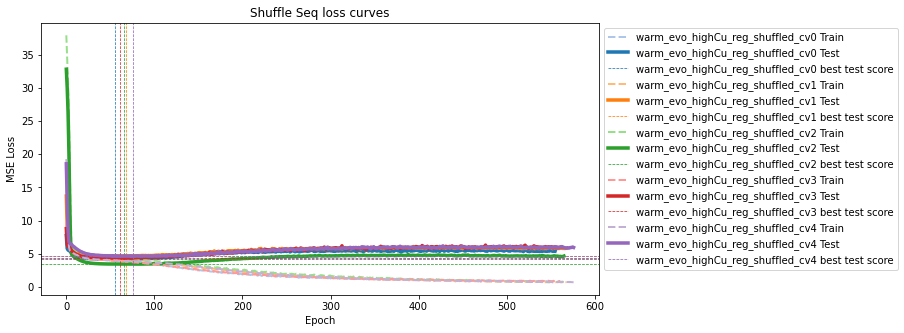

<Figure size 432x288 with 0 Axes>

In [39]:
tu.quick_loss_plot(
    [model_res_regr[x]['data_label'][0] for x in model_res_regr if "shuffle" not in x],
    title="Regular Seq loss curves",
    loss_str = "MSE Loss",
    save_file = 'out_warmStart_highCu_regr/regular_seq_W:evo_loss_plot.png'
)

tu.quick_loss_plot(
    [model_res_regr[x]['data_label'][0] for x in model_res_regr if "shuffle" in x],
    title="Shuffle Seq loss curves",
    loss_str = "MSE Loss",
    save_file = 'out_warmStart_highCu_regr/shuffle_seq_W:evo_loss_plot.png'
)